In [1]:
import numpy as np
import glob
import skimage
import skimage.io
import skimage.transform
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
from sklearn.decomposition import PCA
import random
from data import Dataset
from tqdm import tqdm

def corrcoef(x, y):
    """Return Pearson product-moment correlations coefficients.

    This is a wrapper around `np.corrcoef` to avoid:
        `RuntimeWarning: invalid value encountered in true_divide`.
    """

    assert len(x) > 0, len(x)
    assert len(y) > 0, len(y)
    assert len(x) == len(y), (len(x), len(y))

    is_x_deterministic = np.all(x == x[0])  # i.e. array filled with a unique value
    is_y_deterministic = np.all(y == y[0])  # i.e. array filled with a unique value
    if is_x_deterministic and is_y_deterministic:
        r = 1.0
    elif is_x_deterministic or is_y_deterministic:
        r = 0.0
    else:
        r = np.corrcoef(x, y)[0, 1]

    return r

In [2]:
#I create the "true" gaussian filter function that my fitting procedure should retrieve

x, y = np.meshgrid(np.linspace(0,108,108), np.linspace(0,108,108))
def gaussian_filt(x,y,x0,y0,sx,sy,theta,amp):
    x1=x*np.cos(theta)-y*np.sin(theta)-x0*np.cos(theta)+y0*np.sin(theta)
    y1=y*np.cos(theta)+x*np.sin(theta)-y0*np.cos(theta)-x0*np.sin(theta)
    return amp*np.exp(-((x1**2. / (2. * sx**2.) + (y1)**2. / (2. * sy**2.))))

#then I create a function that computes the responses of the cell given a certain filter

def contrast_model(images,x0,y0,sx,sy,theta,amp,l_0):
    responses=np.zeros((images.shape[0]))
    x, y = np.meshgrid(np.linspace(0,108,108), np.linspace(0,108,108))
    filter_ = gaussian_filt(x,y,x0,y0,sx,sy,theta,amp)
    for i in range(images.shape[0]):
        responses[i]= np.dot(((images[i]-l_0)**2).flatten(), filter_.flatten())
        
    return responses

#this is the function that computes the lsta prediction of the contrast model with l_0 as free param
def contrast_model_lstas(images,x0,y0,dx,dy,theta,amp,l_0):
    ctr_lstas=np.zeros(images.shape)
    x, y = np.meshgrid(np.linspace(0,108,108), np.linspace(0,108,108))
    filt=gaussian_filt(x,y,x0,y0,dx,dy,theta,amp)
    for i in range(images.shape[0]):
        ctr_lstas[i]=2*(images[i]-l_0)*filt
    return ctr_lstas

#this is the function that computes the lsta prediction of the contrast model with l_0 as LSTA*image
def contrast_model_dotlstas(images,x0,y0,dx,dy,theta,amp):
    ctr_lstas=np.zeros(images.shape)
    x, y = np.meshgrid(np.linspace(0,108,108), np.linspace(0,108,108))
    filt=gaussian_filt(x,y,x0,y0,dx,dy,theta,amp)
    for i in range(images.shape[0]):
        l_0=np.dot(LSTAs_set[i].flatten(),images[i].flatten())  #/LSTAs_set[i].sum()
        ctr_lstas[i]=2*(images[i]-l_0)*filt
    return ctr_lstas

#this is the function that computes the lsta prediction of the contrast model with l_0 as binned_LSTA*binned_image
def contrast_model_dotlstas_binned(images,x0,y0,dx,dy,theta,amp):
    ctr_lstas=np.zeros(images.shape)
    x, y = np.meshgrid(np.linspace(0,108,108), np.linspace(0,108,108))
    filt=gaussian_filt(x,y,x0,y0,dx,dy,theta,amp)
    for i in range(images.shape[0]):
        l_0=np.dot(binned_lstas[i].flatten(),images[i].flatten())  #/LSTAs_set[i].sum()
        ctr_lstas[i]=2*(images[i]-l_0)*filt
    return ctr_lstas

#here I want to fit the contrast model on the responses of the cell but with an l_0 that is given by the dot 
#product

def contrast_model2(images,x0,y0,sx,sy,theta,amp):
    responses=np.zeros((images.shape[0]))
    x, y = np.meshgrid(np.linspace(0,108,108), np.linspace(0,108,108))
    filter_ = gaussian_filt(x,y,x0,y0,sx,sy,theta,amp)
    for i in range(images.shape[0]):
        l_0=np.dot(LSTAs_set[i].flatten(),images[i].flatten())
        responses[i]= np.dot(((images[i]-l_0)**2).flatten(), filter_.flatten())
        
    return responses

def contrast_model_lstas_2(images,x0,y0,dx,dy,theta,amp,l_0):
    res=contrast_model_lstas(images,x0,y0,dx,dy,theta,amp,l_0)
    return res.flatten()

def contrast_model_lstas_3(images,x0,y0,dx,dy,theta,amp):
    res=contrast_model_dotlstas(images,x0,y0,dx,dy,theta,amp)
    return res.flatten()

def contrast_model_lstas_4(images,x0,y0,dx,dy,theta,amp):
    res=contrast_model_dotlstas_binned(images,x0,y0,dx,dy,theta,amp)
    return res.flatten()

def random_search(function,input_, target, rn_nb,dot=False,method='lm'):  #'trf','dogbox'
    x0_range=np.arange(10,80,1)
    y0_range=np.arange(10,80,1)
    dx0_range=np.arange(-50,50,.1)
    dy0_range=np.arange(-50,50,.1)
    theta0_range=np.arange(-1.5,1.5,0.01)
    amp0_range=np.arange(0,50,.1)
    l0_range=np.arange(0,5,0.01)

    points=[]
    for run in range(rn_nb):
        x0=random.choice(x0_range)
        y0=random.choice(y0_range)
        dx0=random.choice(dx0_range)
        dy0=random.choice(dy0_range)
        theta0=random.choice(theta0_range)
        amp0=random.choice(amp0_range)
        l0=random.choice(l0_range)
        try:
            if dot:
                best_vals9, covar9 = curve_fit(function, input_, target, p0=[x0,y0,dx0,dy0,theta0,amp0],method=method)
                trial=contrast_model_lstas(binned_imgs,*best_vals9)
                points.append(np.append(best_vals9,((trial.flatten()-binned_lstas.flatten())**2).sum() ))
            else:
                best_vals9, covar9 = curve_fit(function, input_, target, p0=[x0,y0,dx0,dy0,theta0,amp0,l0],method=method)
                trial=contrast_model_lstas(binned_imgs,*best_vals9)
                points.append(np.append(best_vals9,((trial.flatten()-binned_lstas.flatten())**2).sum() ))
        except:
            if dot:
                points.append(np.append(np.zeros(6),10000 ))
            else:
                points.append(np.append(np.zeros(7),10000 ))
        #print(run/rn_nb*100)

    points=np.array(points)
    #print(points.shape,points.argmin(),points[:,-1].min())
    return points[points[:,-1].argmin(),:]

### input import

In [3]:
mouse_expl_var=[]
salam_expl_var=[]
for exp in tqdm([11, 13,17,19, 101,102]):

    # for each experiment, load the dataset
    if exp==11: dataset = Dataset.load("/media/samuele/Samuele_01/Exp_11/analysis/data2_12mixed_tr19.pkl")
    #if exp==12: dataset = Dataset.load("/media/eqs8/Samuele_01/Exp_12/analysis/data2_32mixed_tr21.pkl")
    if exp==13: dataset = Dataset.load("/media/samuele/Samuele_01/Exp_13/analysis/data2_select_tr1.pkl")
    if exp==17: dataset = Dataset.load("/media/samuele/Samuele_01/Exp_17/analysis/data2_41mixed_tr28.pkl")
    if exp==19: dataset = Dataset.load("/media/samuele/Samuele_01/Exp_19/analysis/data2_28mixed_tr35.pkl")
    if exp==101: dataset = Dataset.load("/media/samuele/BC_Samuele/20190523_goodone/analyses/flashed_images/fi/data.pkl")
    if exp==102: dataset = Dataset.load("/media/samuele/Samuele_01/Salamander2/data2_23mixed_tr34.pkl")

    dataset.select_cells('all')
    train_x, train_y = dataset.train()
    val_x, val_y = dataset.val()
    test_x, test_y = dataset.test(averages=False)

    #here I reshape the pickle outputs that have a weird 1
    train_x=train_x[:,:,:,0]
    val_x=val_x[:,:,:,0]
    test_x=test_x[:,:,:,0]

    #for each experiment, load the predicted lstas on the traing set (previously generate through the script baseline_cnn_analyze.py)
    if exp==11: results_folder= "/media/samuele/Samuele_01/Exp_11/analysis/cnn_12mixed_tr19/run_019"
    #if exp==12: results_folder= '/media/eqs8/Samuele_01/Exp_12/analysis/cnn_32mixed_tr21/run_060/'
    if exp==13: results_folder= '/media/samuele/Samuele_01/Exp_13/analysis/cnn_9OFF_tr1/run_097/'
    if exp==17: results_folder= '/media/samuele/Samuele_01/Exp_17/analysis/cnn_41mixed_tr28_repeat/run_026'
    if exp==19: results_folder="/media/samuele/Samuele_01/Exp_19/analysis/cnn_28mixed_tr35/run_019"
    if exp==101:results_folder= '/media/samuele/BC_Samuele/20190523_goodone/analyses/cnn_sys_ident/20200616_025316/run_075/'
    if exp==102:results_folder='/media/samuele/Samuele_01/Salamander2/cnn_23mixed_tr34/run_030'

    train_lstas=np.load(os.path.join(results_folder, 'train_lstas.npy'))

    #for each experiment now I have to have a list of inverting cells and iterate over them

    #the cells indexes listed here are of the ones that were observed by eye to invert
#     if exp==11: inverting_cells_idx=[2,10] #68,388
#     if exp==13: inverting_cells_idx=[1,6]  #186,634
#     if exp==17: inverting_cells_idx=[1,5,6,7,10,12,14,15,16,17,19,21,26,28,29,30,31,32,33,36,37,39]
#                                     #30,116,177,262,339,376,412,515,553,561,680,754,862,892,910,960,962,991,994,1009,1014,1031
#     if exp==19: inverting_cells_idx=[0,1,2,3,4,12,24] #6,33,44,65,79,237,435
#     if exp==101:inverting_cells_idx=[3,5,11,19]  #821,842,871,903
#     if exp==102:inverting_cells_idx=[2,7,9,12] #999,1029,1046,1055
    #41 cells

    #the ones listed here are the intersection between the modelled cells and the cells that were detected to invert
    #by the Berens
    if exp==11: inverting_cells_idx=[2] #68
    if exp==13: inverting_cells_idx=[1,6]  #186,634
    if exp==17: inverting_cells_idx=[1,5,10,21,26,28,29,31,32,39] #30,116,339,754,862,892,910,962,991,1031
    if exp==19: inverting_cells_idx=[12] #237
    if exp==101:inverting_cells_idx=[3,5,19]   #842,871  #[5,11]
    if exp==102:inverting_cells_idx=[2,7,9,12] #999,1029,1046,1055
    #20 cells

    #evaluation of the CNN model on the test data
    cnn_test_predictions=np.load(os.path.join(results_folder, 'test_predictions.npy'))
    #these are the CNN results on the testing set
    cnn_test_predictions=np.mean(cnn_test_predictions,axis=0)
    #I average across repetitions because the model is not stochastic and so for the same image gives always the same prediction

    even_test_y = np.mean(test_y[0::2, :, :], axis=0)  # mean over even repetitions
    odd_test_y = np.mean(test_y[1::2, :, :], axis=0)  # mean over odd repetitions
    reliabilities = []
    accuracies_o = []
    accuracies_e = []
    nb_cells=test_y.shape[-1]
    for cell_nb in range(0, nb_cells):
        reliability = corrcoef(even_test_y[:, cell_nb], odd_test_y[:, cell_nb])
        accuracy_o = corrcoef(cnn_test_predictions[:, cell_nb], odd_test_y[:, cell_nb])
        accuracy_e = corrcoef(cnn_test_predictions[:, cell_nb], even_test_y[:, cell_nb])
        reliabilities.append(reliability)
        accuracies_o.append(accuracy_o)
        accuracies_e.append(accuracy_e)
    reliabilities = np.array(reliabilities)
    accuracies_o = np.array(accuracies_o)
    accuracies_e = np.array(accuracies_e)

    max_explainable_var=2/(1+np.sqrt(1/reliabilities**2))
    #the variance in the true data that is explainable. The unexplainable part is due to noise
    nc_cnn_predicted_variance=(0.5*(accuracies_o+accuracies_e))/np.sqrt(reliabilities)
    #the variance that is actually explained by the model

    #cnn_performance=nc_cnn_predicted_variance/max_explainable_var
    cnn_performance=nc_cnn_predicted_variance**2
    #the percentage of explainable variance that is explained by the model, for all the modelled cells of one experiment 

    for inv_idx in inverting_cells_idx:
        #Let's focus on a cell. Each cell has a separate contrast model
        base=train_lstas[inv_idx]
        LSTAs_set=base.reshape(base.shape[0], base.shape[1]*base.shape[2])
        #do a PCA on the collection of the predicted LSTAs for the single cell
        pca = PCA(n_components=2)
        pca.fit(LSTAs_set)
        #project all the images of the training set on the first two PCs
        PC1=pca.components_[0]
        PC2=pca.components_[1]

        resh_training=train_x.reshape(train_x.shape[0], train_x.shape[1]*train_x.shape[2])
        project=[]
        for image in resh_training:
            project.append([np.dot(PC1,image),np.dot(PC2,image)])
        project=np.array(project)    
        pt_x=project[:,0]  #the projection values of each image on PC1
        pt_y=project[:,1]  #the projection values of each image on PC2

    #     #project also the LSTAs on the same components
    #     arrowheads=[]
    #     for image in LSTAs_set:
    #         arrowheads.append([np.dot(PC1,image),np.dot(PC2,image)])
    #     arrowheads=np.array(arrowheads)
    #     dx=arrowheads[:,0]  #the projection values of each LSTA on PC1
    #     dy=arrowheads[:,1]  #the projection values of each LSTA on PC2

        #principal components space discretization. I bin the images (and the corresponding LSTAs) averaging together
        #the ones whose projection values fall inside a certain bin
        x_bins=20   # of bins (arrows) I want along x    
        y_bins=20   # of bins (arrows) I want along y
        dx=(pt_x.max()-pt_x.min())/x_bins   #bin size of x
        dy=(pt_y.max()-pt_y.min())/y_bins   #bin size of y

        binned_imgs=[]
        binned_lstas=[]
        for x_tick in range(x_bins):
            x_val=pt_x.min()+x_tick*dx
            for y_tick in range(y_bins):
                y_val=pt_y.min()+y_tick*dy
                temp_img=np.zeros((108,108))
                temp_lsta=np.zeros((108,108))
                nb=0
                for i,img in enumerate(project):
                    if x_val<=img[0]<x_val+dx and y_val<=img[1]<y_val+dy:
                        temp_img+=train_x[i]
                        temp_lsta+=base[i]
                        nb+=1
                if nb==0:
                    continue
        #             binned_imgs.append(np.zeros((108,108)))
        #             binned_lstas.append(np.zeros((108,108)))
                else:
                    binned_imgs.append(temp_img/nb)
                    binned_lstas.append(temp_lsta/nb)
        binned_imgs=np.array(binned_imgs)
        binned_lstas=np.array(binned_lstas)

        #just a reshape of the binning output for the scalar product
        resh_binned_imgs=binned_imgs.reshape(binned_imgs.shape[0],binned_imgs.shape[1]*binned_imgs.shape[2])
        resh_binned_lstas=binned_lstas.reshape(binned_lstas.shape[0],binned_lstas.shape[1]*binned_lstas.shape[2])

        binned_arrowtails=[]
        for bin_img in resh_binned_imgs:
            binned_arrowtails.append([np.dot(PC1,bin_img),np.dot(PC2,bin_img)])
        binned_arrowtails=np.array(binned_arrowtails) #the projection values of the binned images

        binned_arrowheads=[]
        for bin_lsta in resh_binned_lstas:
            binned_arrowheads.append([np.dot(PC1,bin_lsta),np.dot(PC2,bin_lsta)])
        binned_arrowheads=np.array(binned_arrowheads) #the projection values of the binned lstas

        #I use the projections to fit the contrast model so to reproduce best the binned lstas
        #I do a random search for the initialization parameters
        best_vals6=random_search(contrast_model_lstas_2,binned_imgs,binned_lstas.flatten(),10)

#         #I use the fitted contrast model to predict a new set of LSTAs (as the contrast model derivative)
#         ctr_lastas6=contrast_model_lstas(binned_imgs,*best_vals6[:-1])
#         mod6_lasta_set=ctr_lastas6.reshape(ctr_lastas6.shape[0], ctr_lastas6.shape[1]*ctr_lastas6.shape[2])
#         model_arrows6=[]
#         #and I project these new lstas on the same two PCs
#         for ctr_lsta in mod6_lasta_set:
#             model_arrows6.append([np.dot(PC1,ctr_lsta),np.dot(PC2,ctr_lsta)])
#         model_arrows6=np.array(model_arrows6)

#         dx_mod6=model_arrows6[:,0] #proj values of the contrast-model-predicted lstas along PC1
#         dy_mod6=model_arrows6[:,1] #proj values of the contrast-model-predicted lstas along PC2



        #evaluation of the contrast model on the data
    #I use the fitted contrast model to predict the response of the cell to the images of the testing set
        contr_test_predictions=contrast_model(test_x,*best_vals6[:-1])
        even_test_y_ss = np.mean(test_y[0::2, :, inv_idx], axis=0)  # mean over even repetitions for one cell
        odd_test_y_ss = np.mean(test_y[1::2, :, inv_idx], axis=0)  # mean over odd repetitions  for one cell

        reliability_ss = corrcoef(even_test_y_ss, odd_test_y_ss)
        accuracy_o_ss = corrcoef(contr_test_predictions, odd_test_y_ss)
        accuracy_e_ss = corrcoef(contr_test_predictions, even_test_y_ss)

        max_explainable_var_ss=2/(1+np.sqrt(1/reliability_ss))
        #the variance in the true data that is explainable. The unexplainable part is due to noise

        nc_contr_predicted_variance=(0.5*(accuracy_o_ss+accuracy_e_ss))/np.sqrt(reliability_ss)
        #the variance that is actually explained by the model

        #contr_performance=nc_contr_predicted_variance/max_explainable_var_ss
        contr_performance=nc_contr_predicted_variance**2
        #the percentage of explainable variance that is explained by the model

        #evaluation of the contrast model with respect to the CNN
        cross_model_accuracy = corrcoef(contr_test_predictions, cnn_test_predictions[:,inv_idx])


        if exp>100: salam_expl_var.append([cnn_performance[inv_idx], contr_performance, cross_model_accuracy])
        else: mouse_expl_var.append([cnn_performance[inv_idx], contr_performance, cross_model_accuracy])

















100%|██████████| 6/6 [29:21<00:00, 293.64s/it]


In [5]:
mouse_expl_var

[[0.9889896812919918, 0.6837757205058631, 0.7589460002382923],
 [0.9621487102504535, 0.8924060787882203, 0.9596725965078481],
 [0.9704556922736612, 0.7638087733143974, 0.8440677724958],
 [0.9498798268539771, 0.9891344473535328, 0.9439406522991682],
 [0.7330189468575048, 0.6403058920091927, 0.7283810960970485],
 [0.7303884583063321, 0.612984706623252, 0.8417338231169399],
 [0.5102183384030425, 0.5555791340863938, 0.7226564389301384],
 [0.663641167168355, 0.6106692000203089, 0.7506366277830414],
 [0.7532027203050572, 0.6658929441538238, 0.8360225608956497],
 [0.7445938505120719, 0.658849214805602, 0.7634125380074996],
 [0.947871959644592, 0.9242978075564705, 0.9416487664809788],
 [0.924504773944985, 0.7940007213713128, 0.8798751363504639],
 [0.4100795969628923, 0.4831441220674999, 0.6713826963293573],
 [0.542204826182657, 0.23800065944476617, 0.4200280232954209]]

In [6]:
salam_expl_var #old

[[0.9763389792192702, 0.810195211633622, 0.8369022456021148],
 [0.7993073798830606, 0.6794180876217573, 0.7985549884909205],
 [0.9142937052011249, 0.8188406588071487, 0.9135444075303678],
 [0.8493257639753911, 0.6690037232740964, 0.737265342292405],
 [0.8377778141987092, 0.540507671024896, 0.6913367300728429],
 [0.8693183458746377, 0.6889065535047615, 0.6743036249648126]]

In [4]:
np.save('/home/samuele/Data_analysis/CNNvsContrast_performance_mouse_invertingcellsBerens_correct',mouse_expl_var)
np.save('/home/samuele/Data_analysis/CNNvsContrast_performance_salamander_invertingcellsBerens_correct',salam_expl_var)

## Different approaches were tried. It was tried to fit the model on the responses instead of the lstas and it was tried to pass the l_0 as a dot product instead of making it a free parameter. it was tried not to bin the stimulus space. Those approaches though did not work. So the stimulus space is binned, l_0 is gven as a free parameter and the model is fitted to reproduce the lstas, not the responses

### I discretize the space in order to avoid that the arrows that are more frequent will bias my parameters estimation

/home/eqs8/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


0.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
(10, 8) 44 26.001794039238153
[ 6.35033782e+01  5.43018223e+01 -2.36360507e+00  2.06793687e+00
  8.12220158e-01  5.14399992e-02 -4.35423716e-01  2.60017940e+01]


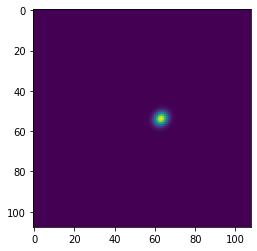

In [81]:
#here I give l_0 as a free parameter and train the model on the lstas

# init_vals6 = [68, 54, 20,20,0,5,0.1]
# best_vals6, covar6 = curve_fit(contrast_model_lstas_2, binned_imgs, binned_lstas.flatten(), p0=init_vals6,method='trf')
best_vals6=random_search(contrast_model_lstas_2,binned_imgs,binned_lstas.flatten(),10)
print(best_vals6)

x, y = np.meshgrid(np.linspace(0,108,108), np.linspace(0,108,108))
plt.figure()
plt.imshow(gaussian_filt(x,y,*best_vals6[:-2]))

## Plot the fitted arrow graph with performances evaluations

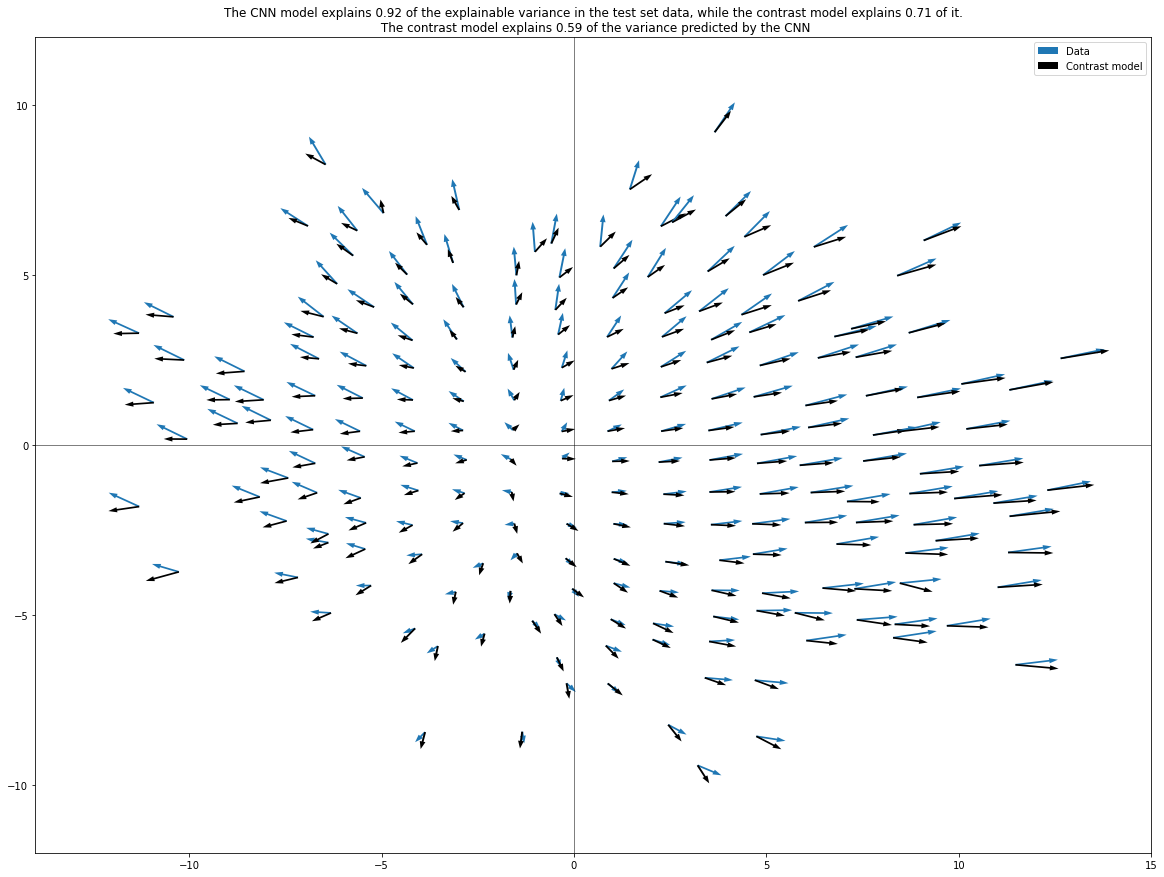

In [88]:
Plotting_folder='/home/eqs8/Data_analysis/Contrast_Model_output/'
#the folder in which the plot is to be saved

plt.figure(figsize=(20,15))
for i,j in enumerate(binned_arrowtails[:,0]):
    if i==0:
        plt.arrow(j,binned_arrowtails[i,1],binned_arrowheads[i,0],binned_arrowheads[i,1],width=0.05,lw=0,label='Data')
        plt.arrow(j,binned_arrowtails[i,1],dx_mod6[i],dy_mod6[i],width=0.05, color='k',lw=0,label='Contrast model')
    else:
        plt.arrow(j,binned_arrowtails[i,1],binned_arrowheads[i,0],binned_arrowheads[i,1],width=0.05,lw=0,label=None)
        plt.arrow(j,binned_arrowtails[i,1],dx_mod6[i],dy_mod6[i],width=0.05, color='k',lw=0,label=None)

plt.title("The CNN model explains {0:.2f} of the explainable variance in the test set data, while the contrast model explains {1:.2f} of it.\n The contrast model explains {2:.2f} of the variance predicted by the CNN".format(cnn_performance[cell],contr_performance,cross_model_accuracy))
plt.xlim([-14,15])
plt.ylim([-12,12])
plt.axvline(0,color='k',lw=0.5)
plt.axhline(0,color='k',lw=0.5)

plt.savefig(Plotting_folder+'Arrowgraph_cell561_Exp17')
plt.legend()
plt.show()    
